# Generative Spaces (ABM)

In this workshop we will learn how to construct a ABM (Agent Based Model) with spatial behaviours, that is capable of configuring the space. This file is a simplified version of Generative Spatial Agent Based Models. For further information, you can find more advanced versions here:

* [Object Oriented version](https://github.com/shervinazadi/spatial_computing_workshops/blob/master/notebooks/w3_generative_spaces.ipynb)
* [Vectorized version](https://topogenesis.readthedocs.io/notebooks/random_walker)

## 0. Initialization

### 0.1. Load required libraries

In [75]:
# !pip install pyvista==0.28.1 ipyvtklink

In [76]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import pandas as pd
import numpy as np

np.random.seed(0)

## Parameter settings

In [77]:
# The number of frames of the growth model
n_frames = 30

### 0.2. Define the Neighborhood (Stencil)

In [78]:
# creating neighborhood definition
stencil = tg.create_stencil("von_neumann", 1, 1)
# setting the center to zero
stencil.set_index([0,0,0], 0)
print(stencil)

[[[0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 1 0]
  [1 0 1]
  [0 1 0]]

 [[0 0 0]
  [0 1 0]
  [0 0 0]]]


### 0.3 Visualize the Stencil

In [79]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = np.array(stencil.shape) + 1
# The bottom left corner of the data set
grid.origin = [0,0,0]
# These are the cell sizes along each axis
grid.spacing = [1,1,1]

# Add the data values to the cell data
grid.cell_arrays["values"] = stencil.flatten(order="F")  # Flatten the stencil
threshed = grid.threshold([0.9, 1.1])

# adding the voxels: light red
p.add_mesh(threshed, show_edges=True, color="#ff8fa3", opacity=0.3)

# plotting
p.show(use_ipyvtk=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

[(7.295554957734411, 7.295554957734411, 7.295554957734411),
 (1.5, 1.5, 1.5),
 (0.0, 0.0, 1.0)]

## 1. Setup the Environment

### 1.1. Load the envelope lattice as the avialbility lattice

In [80]:
# loading the lattice from csv
lattice_path = os.path.relpath('../Data/dynamic output/voxelized_envelope.csv')
avail_lattice = tg.lattice_from_csv(lattice_path)
init_avail_lattice = tg.to_lattice(np.copy(avail_lattice), avail_lattice)
len(avail_lattice)

18

### 1.2 Load Program

In [81]:
# Load preference
program_complete = pd.read_csv("../Data/raw data/Programme_pref.csv")
program_complete = program_complete.drop(["sunlight"], 1)
program_complete['noise_field'] *= -1
program_complete['dist_entrance'] *= -1
program_complete['dist_fac'] *= -1
program_complete

,space_name,space_id,noise_field,dist_entrance,dist_fac,skyview
0,Student Housing 1 p,0,-0.4,-0.55,-0.87,0.6
1,Student Housing 4 p,1,-0.4,-0.55,-0.87,0.6
2,Assisted Living,2,-0.8,-0.40,-0.93,0.8
3,Starter Housing,3,-0.6,-0.60,-0.93,0.6
4,Underground Parking4,0,-0.8,-0.07,-0.20,0.0
5,Bicycle parking,5,-0.0,-0.85,-0.07,0.0
6,Vegetation/park,6,-0.5,-0.35,-0.53,0.0
7,Workshops,7,-0.3,-0.65,-0.70,0.4
8,Fab-Labs,8,-0.2,-0.50,-0.60,0.4
9,Co-working Space,9,-0.5,-0.60,-0.67,0.4


In [82]:
# Simplify it
program_prefs = program_complete.drop(["space_name","space_id"], 1)
program_prefs

,noise_field,dist_entrance,dist_fac,skyview
0,-0.4,-0.55,-0.87,0.6
1,-0.4,-0.55,-0.87,0.6
2,-0.8,-0.40,-0.93,0.8
3,-0.6,-0.60,-0.93,0.6
4,-0.8,-0.07,-0.20,0.0
5,-0.0,-0.85,-0.07,0.0
6,-0.5,-0.35,-0.53,0.0
7,-0.3,-0.65,-0.70,0.4
8,-0.2,-0.50,-0.60,0.4
9,-0.5,-0.60,-0.67,0.4


In [83]:
# Load agent sizes
sizes_complete = pd.read_csv("../Data/raw data/Agent_sizes.csv")
display(sizes_complete)

,Agent,Agent_id,Area,Part,Percentage
0,Student housing (1 person),0,1200,0.026,2.59
1,Student housing (4 persons),1,4800,0.104,10.37
2,Assisted living (30 units),2,1800,0.039,3.89
3,Starter housing (100 units),3,9000,0.194,19.44
4,Parking spaces (minimal of 0.5 per apartement),4,2500,0.054,5.40
5,Bicycle parking,5,990,0.021,2.14
6,Vegetation,6,14000,0.302,30.25
7,Workshops,7,2000,0.043,4.32
8,Fab-Labs,8,1000,0.022,2.16
9,Co-working space,9,3000,0.065,6.48


#### Calculating agent sizes in voxels

In [84]:
agent_sizes = []
for i, row in sizes_complete.iterrows():
    part = row['Part']
    agent_sizes.append(part) 

agent_sizes

[0.026,
 0.104,
 0.039,
 0.194,
 0.054,
 0.021,
 0.302,
 0.043,
 0.022,
 0.065,
 0.022,
 0.014,
 0.007,
 0.004,
 0.013,
 0.002,
 0.011,
 0.022,
 0.004,
 0.022,
 0.007,
 0.002]

### 1.2 Load the value fields

In [85]:
# loading the lattice from csv
fields = {}
for f in program_prefs.columns:
    lattice_path = os.path.relpath('../Data/dynamic output/' + f + '.csv') # should care naming of csv
    fields[f] = tg.lattice_from_csv(lattice_path)

### 1.3. Initialize the Agents

In [86]:
# # initialize the occupation lattice
# occ_lattice = avail_lattice * 0 - 1 # -1 means no agent is using it

# # Finding the index of the available voxels in avail_lattice
# avail_flat = avail_lattice.flatten()
# avail_index = np.array(np.where(avail_lattice)).T

# # Randomly choosing three available voxels
# agn_num = len(program_complete) 

# select_id = np.random.choice(len(avail_index), agn_num)
# agn_origins = avail_index[select_id] # Transform choosing 3D index to choose 1D and then locate it back to 3D

# # adding the origins to the agents locations
# agn_locs = []
# # for each agent origin ... 
# for a_id, a_origin in enumerate(agn_origins):
#     # add the origin to the list of agent locations
#     agn_locs.append([a_origin])
#     # set the origin in availablity lattice as 0 (UNavailable)
#     avail_lattice[tuple(a_origin)] = 0
#     # set the origin in occupation lattice as the agent id (a_id)
#     occ_lattice[tuple(a_origin)] = a_id

In [91]:
# initialize the occupation lattice
occ_lattice = avail_lattice * 0 - 1 # -1 means no agent is using it

agn_locs = []
for a_id, a_prefs in program_complete.iterrows():
    avail_index = np.array(np.where(avail_lattice)).T
    a_eval = np.ones(len(avail_index))
    for f in program_prefs.columns:
        vals = fields[f][avail_index[:,0], avail_index[:,1], avail_index[:,2]]
        # raise the the raw value to the power of preference weight of the agent
        a_weighted_vals = vals ** a_prefs[f]
        # multiply them to the previous weighted values
        a_eval *= a_weighted_vals
    for i in range(len(a_eval)):
        if a_eval[i] == np.inf:
            a_eval[i] = -1
    selected_int = np.argmax(a_eval)
    agn_locs.append([avail_index[selected_int]])
    avail_lattice[tuple(avail_index[selected_int])] = 0
    occ_lattice[tuple(avail_index[selected_int])] = a_id

divide by zero encountered in power


In [92]:
agn_locs

[[array([4, 3, 2], dtype=int64)],
 [array([16, 12,  1], dtype=int64)],
 [array([16, 11,  1], dtype=int64)],
 [array([16,  3,  2], dtype=int64)],
 [array([ 3, 10,  3], dtype=int64)],
 [array([13, 12,  1], dtype=int64)],
 [array([2, 4, 1], dtype=int64)],
 [array([14,  2,  2], dtype=int64)],
 [array([16,  4,  1], dtype=int64)],
 [array([5, 2, 1], dtype=int64)],
 [array([13,  2,  1], dtype=int64)],
 [array([14, 12,  2], dtype=int64)],
 [array([14, 11,  2], dtype=int64)],
 [array([14, 10,  1], dtype=int64)],
 [array([8, 8, 1], dtype=int64)],
 [array([ 4, 10,  3], dtype=int64)],
 [array([3, 9, 2], dtype=int64)],
 [array([ 5, 10,  2], dtype=int64)],
 [array([14, 14,  2], dtype=int64)],
 [array([13, 11,  1], dtype=int64)],
 [array([5, 3, 1], dtype=int64)],
 [array([2, 3, 3], dtype=int64)]]

### 1.4. Visualize the environment

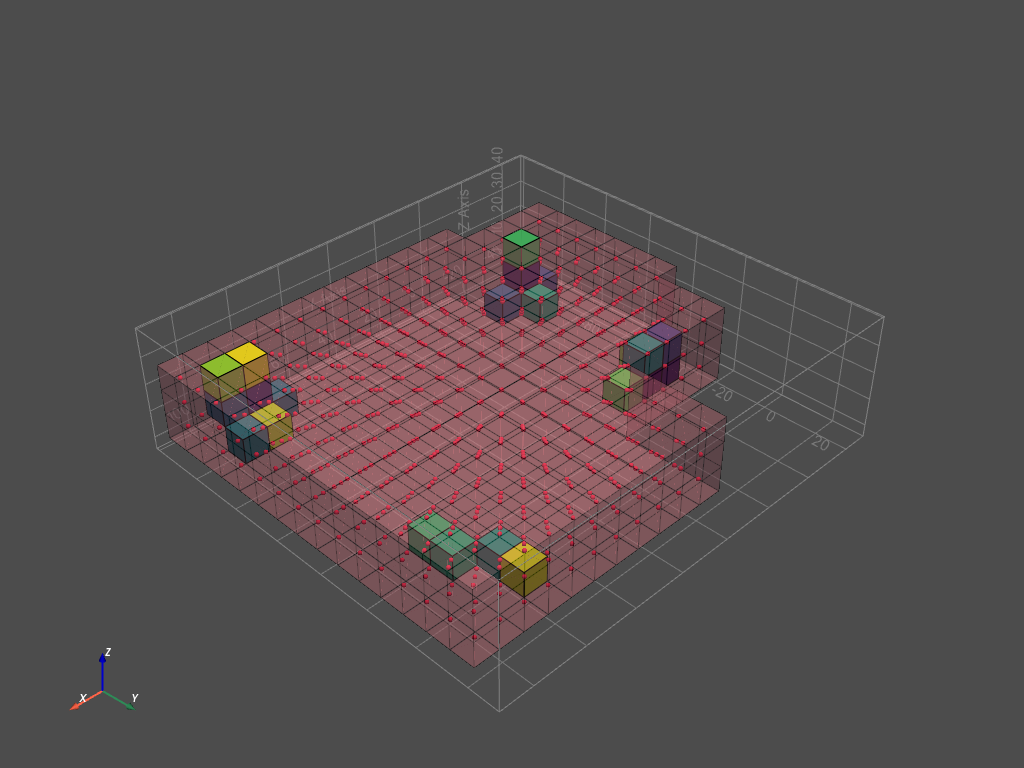

[(285.05138968497397, 208.55138968497394, 271.55138968497397),
 (31.5, -45.0, 18.0),
 (0.0, 0.0, 1.0)]

In [69]:
p = pv.Plotter(notebook=True)

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(occ_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = occ_lattice.minbound - occ_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = occ_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#777777")

# Add the data values to the cell data
grid.cell_arrays["Agents"] = occ_lattice.flatten(order="F").astype(int)  # Flatten the array!
# filtering the voxels
threshed = grid.threshold([-0.1, agn_num - 0.9])
# adding the voxels
p.add_mesh(threshed, show_edges=True, opacity=1.0, show_scalar_bar=False)

# adding the availability lattice
init_avail_lattice.fast_vis(p)

p.show()

## 2. ABM Simulation (Agent Based Space Occupation)

### 2.1. Running the simulation

In [70]:
program_complete

,space_name,space_id,noise_field,dist_entrance,dist_fac,skyview
0,Student Housing 1 p,0,-0.4,-0.55,-0.87,0.6
1,Student Housing 4 p,1,-0.4,-0.55,-0.87,0.6
2,Assisted Living,2,-0.8,-0.40,-0.93,0.8
3,Starter Housing,3,-0.6,-0.60,-0.93,0.6
4,Underground Parking4,0,-0.8,-0.07,-0.20,0.0
5,Bicycle parking,5,-0.0,-0.85,-0.07,0.0
6,Vegetation/park,6,-0.5,-0.35,-0.53,0.0
7,Workshops,7,-0.3,-0.65,-0.70,0.4
8,Fab-Labs,8,-0.2,-0.50,-0.60,0.4
9,Co-working Space,9,-0.5,-0.60,-0.67,0.4


In [71]:
program_test = pd.read_csv("../Data/raw data/adjacency_matrix.csv")
program_test = program_test.drop(["Unnamed: 0"], 1)
program_test

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,0.1,0.0,0.0,0.0,0.6,0.1,0.0,0.0,0.0,...,0.0,0.0,0.3,0.2,0.0,0.0,0.0,0.9,0.9,0.1
1,0.1,1.0,0.0,0.0,0.0,0.6,0.0,0.0,0.1,0.0,...,0.2,0.8,0.2,0.0,0.3,0.2,0.0,0.8,0.0,0.6
2,0.0,0.0,1.0,0.4,0.2,0.0,0.1,0.2,0.0,0.0,...,0.0,0.0,0.1,0.1,0.1,0.2,0.6,0.3,0.1,0.0
3,0.0,0.0,0.4,1.0,0.9,0.0,1.0,0.0,0.1,0.8,...,0.2,0.6,0.2,0.2,0.0,0.2,0.3,0.9,0.6,0.0
4,0.0,0.0,0.2,0.9,1.0,0.0,0.0,0.0,0.4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.9,0.2,0.0
5,0.6,0.6,0.0,0.0,0.0,1.0,0.2,0.0,0.0,0.0,...,0.1,0.2,0.1,0.0,0.0,0.2,0.0,0.2,0.0,0.0
6,0.1,0.0,0.1,1.0,0.0,0.2,1.0,0.1,0.0,0.0,...,0.1,0.2,0.0,0.1,0.1,0.1,0.5,0.0,0.0,0.4
7,0.0,0.0,0.2,0.0,0.0,0.0,0.1,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.1,0.0,0.1,0.4,0.0,0.0,0.0,1.0,0.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.4,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.8


In [72]:
# To create the second requirement, I will write a method to calculate euclidian distance in lattice
# This part uses the same idea in w2 distance_fields
def distance_field(a_id):
    lattice_cens = init_avail_lattice.centroids_threshold(-1)
    dist_m = []
    for voxel_cen in lattice_cens:
        dist_v = []
        for agent_location in agn_locs[a_id]:
            diff = voxel_cen - agent_location
            diff_p2 = diff**2
            diff_p2s = diff_p2.sum()
            dist = diff_p2s**0.5
            dist_v.append(dist)
        dist_m.append(dist_v)
    dist_m = np.array(dist_m)
    min_dist = dist_m.min(axis=1)
    agent_eu_distance_lattice = tg.to_lattice(min_dist.reshape(init_avail_lattice.shape), init_avail_lattice)
    envelope_eu_dist_lattice = agent_eu_distance_lattice * init_avail_lattice
    envelope_eu_dist_lattice[init_avail_lattice==False] -= 1
    return(envelope_eu_dist_lattice)

# initialize fields
for a_id, a_prefs in program_complete.iterrows():
    fields[a_id] = distance_field(a_id)
        

In [ ]:
# make a deep copy of occupation lattice
cur_occ_lattice = tg.to_lattice(np.copy(occ_lattice), occ_lattice)
# initialzing the list of frames
frames = [cur_occ_lattice]

# setting the time variable to 0
t = 0

# main feedback loop of the simulation (for each time step ...)
while t<n_frames: # For every time
    # for each agent ...
    for a_id, a_prefs in program_complete.iterrows():
        # retrieve the list of the locations of the current agent
        a_locs = agn_locs[a_id]
        # initialize the list of free neighbours
        free_neighs = []
        # for each location of the agent
        for loc in a_locs:
            # retrieve the list of neighbours of the agent based on the stencil
            neighs = avail_lattice.find_neighbours_masked(stencil, loc = loc)
            # for each neighbour ... 
            for n in neighs:
                # compute 3D index of neighbour
                neigh_3d_id = np.unravel_index(n, avail_lattice.shape) # for checking availability
                # if the neighbour is available... 
                if avail_lattice[neigh_3d_id]: # True -> Free
                    # add the neighbour to the list of free neighbours
                    free_neighs.append(neigh_3d_id) # Do not care about counting for the second time.
        # check if found any free neighbour
        if len(free_neighs)>0:
            # convert free neighbours to a numpy array
            fns = np.array(free_neighs)

            # find the value of neighbours
            # init the agent value array
            a_eval = np.ones(len(fns)) # First set all values to 1
            # This is the part to make amandment on choosing which block
            # for each field...
            for f in program_prefs.columns: # f represents names
                # find the raw value of free neighbours...
                vals = fields[f][fns[:,0], fns[:,1], fns[:,2]] # vals should be an array of length of fns
                # raise the the raw value to the power of preference weight of the agent
                a_weighted_vals = vals ** a_prefs[f]
                # multiply them to the previous weighted values
                a_eval *= a_weighted_vals
            
            # now this part add the desirable space vicinity into the account
            for s in program_test.columns:
                s = int(s)
                vals = fields[s][fns[:,0], fns[:,1], fns[:,2]]
                a_weighted_vals = vals ** program_test[str(a_id)][s]
                a_eval *= a_weighted_vals

            # This is the part that takes square shape of room into the account
            square_weight = 0.1
            free_neighs_count = []
            # count can find how many times a location appears
            for free_neigh in free_neighs:
                free_neighs_count.append(free_neighs.count(free_neigh))
            # 0.1 can be modified, I choose it to make it less effective (check x^0.1 graph at Z)
            # If a location is pointed for several times, it refers to more squared shape
            a_weighted_square = np.array(free_neighs_count) ** square_weight
            a_eval *= a_weighted_square

            # Here, when it reaches the maximum space needed, start to evaluate inner voxels
            current_length = np.copy(len(a_locs))
            # This part means nothing, just for prevention of bugs
            i_eval = np.zeros(current_length)
            # max_space can be modified, or iterable (max_space[a_id])
            #max_space_raw = agent_sizes[a_id] * avail_lattice.size
            #max_space = np.rint(max_space_raw)
            max_space = 20
            # If the space occupied by this agent reaches designated
            if current_length >= max_space:
                i_eval = np.ones(current_length)
                # The following parts do exactly the same calculations
                # Calculating fields
                for f in program_prefs.columns:
                    vals = fields[f][np.array(a_locs)[:,0], np.array(a_locs)[:,1], np.array(a_locs)[:,2]]
                    a_weighted_vals = vals ** a_prefs[f]
                    i_eval *= a_weighted_vals

                # Calculating closeness
                for s in program_test.columns:
                    s = int(s)
                    vals = fields[s][np.array(a_locs)[:,0], np.array(a_locs)[:,1], np.array(a_locs)[:,2]]
                    a_weighted_vals = vals ** program_test[str(a_id)][s]
                    i_eval *= a_weighted_vals
                
                # Calculating squareness is bit different but the idea is same.
                i_neighs_count = np.zeros(current_length)
                for id,loc in enumerate(a_locs):
                    # Find neighbors of each point in location
                    neighs = init_avail_lattice.find_neighbours_masked(stencil, loc = loc)
                    for n in neighs:
                        # Use occ_lattice == a_id to check if the neighborhoods of that point are the same agent.
                        neigh_3d_id = np.unravel_index(n, avail_lattice.shape)
                        i_neighs_count[id] += (occ_lattice==a_id)[neigh_3d_id]
                i_weighted_square = np.array(i_neighs_count) ** square_weight
                i_eval *= i_weighted_square

            # select the inner with lowest evaluation
            selected_int_inner = np.argmin(i_eval)
            # select the neighbour with highest evaluation
            selected_int = np.argmax(a_eval)

            # If the agent reaches the required space, and the new free neighbour is better
            # Then we have to remove the old voxel
            if (current_length >= max_space) and i_eval[selected_int_inner] < a_eval[selected_int]:
                selected_inner_3d_id = tuple(a_locs[selected_int_inner])
                selected_inner_loc = a_locs[selected_int_inner]
                agn_locs[a_id].pop(selected_int_inner)
                avail_lattice[selected_inner_3d_id] = 1
                occ_lattice[selected_inner_3d_id] = -1

            # If the agent does not reach the required space, or we already removed old voxel
            # Then we need to add new voxel
            if (not current_length >= max_space) or (current_length >= max_space and i_eval[selected_int_inner] < a_eval[selected_int]):
                # find 3D integer index of selected neighbour
                selected_neigh_3d_id = free_neighs[selected_int]
                # find the location of the newly selected neighbour
                selected_neigh_loc = np.array(selected_neigh_3d_id).flatten()
                # add the newly selected neighbour location to agent locations
                agn_locs[a_id].append(selected_neigh_loc)
                # set the newly selected neighbour as UNavailable (0) in the availability lattice
                avail_lattice[selected_neigh_3d_id] = 0
                # set the newly selected neighbour as OCCUPIED by current agent 
                # (-1 means not-occupied so a_id)
                occ_lattice[selected_neigh_3d_id] = a_id
            
            # If the agent reaches the required space and the old voxels are better, we do nothing
            # Then we can wait other fields to be updated

            # Here distance fields are updated (after agn_locs)
            fields[a_id] = distance_field(a_id)

    # constructing the new lattice
    new_occ_lattice = tg.to_lattice(np.copy(occ_lattice), occ_lattice)
    # adding the new lattice to the list of frames
    frames.append(new_occ_lattice) # For drawing graphes
    # adding one to the time counter
    print(t, end=" ")
    t += 1

### 2.2. Visualizing the simulation

In [ ]:
p = pv.Plotter(notebook=True)

base_lattice = frames[0]

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(base_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = base_lattice.minbound - base_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = base_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding the availability lattice
init_avail_lattice.fast_vis(p)

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#aaaaaa")

def create_mesh(value):
    f = int(value)
    lattice = frames[f]

    # Add the data values to the cell data
    grid.cell_arrays["Agents"] = lattice.flatten(order="F").astype(int)  # Flatten the array!
    # filtering the voxels
    threshed = grid.threshold([-0.1, agn_num - 0.9])
    # adding the voxels
    p.add_mesh(threshed, name='sphere', show_edges=True, opacity=1.0, show_scalar_bar=False)
    return

p.add_slider_widget(create_mesh, [0, n_frames], title='Time', value=0, event_type="always", style="classic")
p.show(use_ipyvtk=True)

### 2.3. Saving lattice frames in CSV

In [ ]:
for i, lattice in enumerate(frames):
    csv_path = os.path.relpath('../Data/dynamic output/abm_animation/abm_f_'+ f'{i:03}' + '.csv')
    lattice.to_csv(csv_path)

### Credits

In [ ]:
__author__ = "Shervin Azadi "
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/spatial_computing_workshops"
__summary__ = "Spatial Computing Design Studio Workshop on Agent Based Models for Generative Spaces"